In [40]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

In [191]:
Z = np.random.randn(10,5)
y = np.random.randn(10)

Z = np.concatenate([Z, np.ones((1, 10)).T], axis=1)
b = np.linalg.lstsq(Z, y)
eps = y - Z @ b[0]
eps.sum()

<ipython-input-191-001b5232f35a>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(Z, y)


5.329070518200751e-15

(10, 6)

- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

# Multiple Testing approach to Survival Analysis


Abstract

In some cases the log-rank test fails to detect the effect much more often than an approaoch based on mulitple testing. We present a survival model demonstrating this case, sating that events in each group follows a Poisson distribution with typical base rate $\lambda_1(t)$ and $\lambda_2(t)$, respectively. Usually, for most measurements, we have $\lambda_1(t) = \lambda_2(t)$, whereas sometimes $\lambda_2(t) > \lambda_1(t)$ (the effect is $\lambda_2(t) - \lambda_1(t)$ for those $t$ when this difference is not zero). The model is implemented in the function `sample_survival_data` in the file `sample_survival_data.py`. 

In this notebook, we use a specific parametrization of sparsity and signal intensity in numerical simulations to find cases where higher criticism and minP tests outperform log-rank. 

To do:
- Replace exact binomial test with exact hypergeometric test. This probably does not change the asymptotic behavior of the test but will likley have better power in practice. 
- Make a power analysis across a phase space, analytically and empirically.
- Derive the asymptotic power of the log-rank test under our model.

In [117]:
def log_rank_test(Nt1, Nt2, alternative = 'two-sided'):
    """
    log-rank test 
    We assume that len(Nt1) == len(Nt2), and that each
    entry in either list represents an event in which
    a change occurs in the number of items in each groups 
    (the change in each group may also be zero)
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    :alternative:   options are: 'greater', 'less', or 'two-sided'
                    with 'greater', test against the alternative that
                    more events occured in Nt2 compared to Nt1
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """
    
    assert(len(Nt1) == len(Nt2))
    T = len(Nt1) - 1

    e0 = np.zeros(T)
    var0 = np.zeros(T)

    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    
    Nt = Nt2 + Nt1
    e0 = Nt2[:-1] * (Ot1 + Ot2) / Nt[:-1]
    var0 = e0 * ( (Nt[:-1] - (Ot1 + Ot2)) /  Nt[:-1] ) * ( Nt1[:-1] / (Nt[:-1] - 1) )
    
    z = np.sum(Ot2 - e0) / np.sqrt(np.sum(var0))

    if alternative == 'greater':
        pval = norm.sf(z)
    elif alternative == 'less':
        pval = norm.cdf(z)
    else:
        pval = 2*norm.cdf(-np.abs(z))

    return z, pval

$$
{\displaystyle E_{i,j}=N_{i,j}{\frac {O_{j}}{N_{j}}}}
$$
$$
{\displaystyle V_{i,j}=E_{i,j}\left({\frac {N_{j}-O_{j}}{N_{j}}}\right)\left({\frac {N_{j}-N_{i,j}}{N_{j}-1}}\right)}
$$

In [76]:
def hypergeom_test(k, M, n, N, alternative = 'greater', randomize=False):
    """
    Exact hypergeometric test
    
    Args:
    -----
    :k:    number of observed Type I objects
    :M:    total number of object
    :n:    total number of Type I objects
    :N:    number of draws
    :randomize:   whether to do a randomized test
    :alternative: type of alternative to consider. Options are: 
                  'greater', 'less', 'two-sided'
    
    Returns:
        Test's P-value
    """
    
    if randomize:
        U = uniform.rvs(size=len(k))
    else:
        U = 0
        
    if alternative=='greater':
        return hypergeom.sf(k, M, n, N) + U * hypergeom.pmf(k, M, n, N)
    if alternative=='less':
        return hypergeom.cdf(k-1, M, n, N) + U * hypergeom.pmf(k, M, n, N)
    raise ValueError("two-sided alternative is not available yet")

In [77]:
def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)


In [78]:
def mutli_pvals(Nt1, Nt2, test='hypergeom',
 randomize=True, alternative='greater'):
    """
    Compute P-values from the pair list of coutns in the two groups.
    We have one p-value per event time.
    An even is a pair (Nt1[i], Nt2[i]).
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :test:  is the type of test to apply (options are: 'hypergeom' or
     'binomial')
    :randomize:  randomized individual tests or not
    :alternative:   type of alternative to use in each test 

    Return:
        P-values 
    """
    
    assert(len(Nt1) == len(Nt2))
    
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    Nt = Nt2 + Nt1
    
    if test == 'binomial':
        n = Ot1 + Ot2
        p = Nt2[:-1] / Nt[:-1]
        x = Ot2
        pvals = binom_test_two_sided(x, n, p, 
                            randomize=randomize, alternative=alternative)
    elif test == 'hypergeom':
        pvals = hypergeom_test(Ot2, Nt[:-1], Nt2[:-1], Ot1 + Ot2,
                           randomize=randomize, alternative=alternative)

    return pvals



In [79]:
def atmoic_experiment(T, N1, N2, eps, mu):
    """
    Sample from survival data; evalaute several test statistics
    
    Args:
    -----
    :T:    time horizon (~ total number of events)
    :N1:   total in group1 at t=0
    :N2:   total in group1 at t=0
    :eps:  fraction of non-null events
    :mu:   intensity of non-null events
    
    """
    
    Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
    return evaluate_test_stats(Nt1, Nt2)


def evaluate_test_stats(Nt1, Nt2, **kwargs):
    """
    Args:
    :Nt1: first list of events
    :Nt2: second list of events
    
    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """

    randomize = kwargs.get('randomize', True)
    alternative = kwargs.get('alternative', 'both')# 'both' != 'two-sided'

    
    test_results = {}

    if alternative == 'both' or alternative == 'greater':
        
        lr, lr_pval = log_rank_test(Nt1, Nt2, alternative='greater')
        test_results['log_rank_greater'] = -np.log(lr_pval) # large values are significant

        pvals_greater = mutli_pvals(Nt1, Nt2, alternative='greater', 
            randomize=randomize)
        mt = MultiTest(pvals_greater, stbl=False) 
                    # if not using stbl=False, then sometimes
                    # HC misses the significance of the strongest effect 
        test_results['hc_greater'] = mt.hc()[0]
        test_results['fisher_greater'] = mt.fisher()[0]
        test_results['min_p_greater'] = mt.minp()
        test_results['berk_jones_greater'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon_greater'] = -np.log(scipy.stats.ranksums(
                                        Nt1, Nt2, alternative='greater').pvalue)

    if alternative == 'both' or alternative == 'less':
        lr, lr_pval = log_rank_test(Nt1, Nt2, alternative='less')
        test_results['log_rank_less'] = -np.log(lr_pval) # large values are significant

        pvals_greater = mutli_pvals(Nt1, Nt2, alternative='less', 
            randomize=randomize)
        mt = MultiTest(pvals_greater, stbl=False) 
                    # if not using stbl=False, then sometimes
                    # HC misses the significance of the strongest effect 
        test_results['hc_less'] = mt.hc()[0]
        test_results['fisher_less'] = mt.fisher()[0]
        test_results['min_p_less'] = mt.minp()
        test_results['berk_jones_less'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon_less'] = -np.log(scipy.stats.ranksums(
                                        Nt1, Nt2, alternative='less').pvalue)


    if alternative == 'two-sided':
        lr, lr_pval = log_rank_test(Nt1, Nt2, alternative='two-sided')
        test_results['log_rank'] = lr

        pvals_greater = mutli_pvals(Nt1, Nt2, alternative='two-sided', 
            randomize=randomize)
        mt = MultiTest(pvals_greater, stbl=False) 
                    # if not using stbl=False, then sometimes
                    # HC misses the significance of the strongest effect 
        test_results['hc'] = mt.hc()[0]
        test_results['fisher'] = mt.fisher()[0]
        test_results['min_p'] = mt.minp()
        test_results['berk_jones'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon'] = -np.log(scipy.stats.ranksums(
                                        Nt1, Nt2, alternative='two-sided').pvalue)

    return test_results


## Sample once:

                 BJ       Fisher         HC   Logrank       minP   wilcoxon
null_95q   6.911782  4071.702032   4.777988  1.960859  10.620356  14.365465
observed  13.414174  4086.211678  44.721315  2.968792  21.422611  20.926523
is_sig     1.000000     1.000000   1.000000  1.000000   1.000000   1.000000
-------------------------------------------------------------

Fliping roles of the lists:
                BJ       Fisher        HC   Logrank       minP   wilcoxon
null_95q  6.911782  4071.702032  4.777988  1.960859  10.620356  14.365465
observed  3.906726  3897.657871  0.161156  2.968792   6.429350  20.926523
is_sig    0.000000     0.000000  0.000000  1.000000   0.000000   1.000000


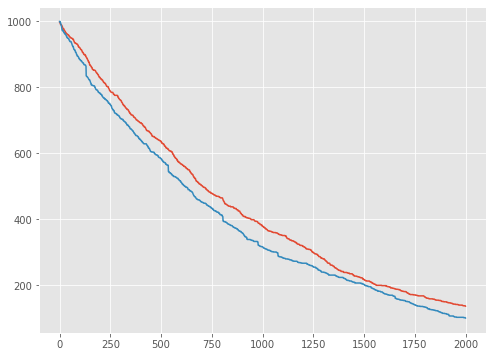

In [80]:
# single experiment non-null

T = 2000
N1 = N2 = 1000
beta = .7         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
mu = .02        # signal strength

Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)

lr, lr_pval = log_rank_test(Nt1, Nt2)
pvals = mutli_pvals(Nt1, Nt2)
mt = MultiTest(pvals, stbl=False)

df_null = pd.read_csv(f"under_null_T{T}_N{N1}.csv").drop('Unnamed: 0', axis=1)
r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher()[0],
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

print("-------------------------------------------------------------\n")
print("Fliping roles of the lists:")
lr, lr_pval = log_rank_test(Nt2, Nt1)

pvals = mutli_pvals(Nt2, Nt1)
mt = MultiTest(pvals, stbl=False)

df_null = pd.read_csv(f"under_null_T{T}_N{N1}.csv").drop('Unnamed: 0', axis=1)
r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher()[0],
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

tt = np.arange(T)
plt.plot(tt, Nt1[1:])
plt.plot(tt, Nt2[1:])
plt.show()
#pd.DataFrame({'N1' : Nt1, 'N2' : Nt2}).to_csv(f'surv_mu{mu}_eps{eps}.csv')


## Atomic experiment:

In [118]:
Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
evaluate_test_stats(Nt1, Nt2, randomized=True, alternative='both')

> <ipython-input-117-d50e2ec520cf>(38)log_rank_test()
-> if alternative == 'greater':
4.0997096164286715
2.06834424669934e-05
0.999979316557533
'greater'
> <ipython-input-117-d50e2ec520cf>(39)log_rank_test()
-> pval = norm.sf(z)
> <ipython-input-117-d50e2ec520cf>(38)log_rank_test()
-> if alternative == 'greater':
'less'
4.0997096164286715
0.999979316557533
> <ipython-input-117-d50e2ec520cf>(40)log_rank_test()
-> elif alternative == 'less':
> <ipython-input-117-d50e2ec520cf>(41)log_rank_test()
-> pval = norm.cdf(z)
> <ipython-input-117-d50e2ec520cf>(45)log_rank_test()
-> return z, pval
0.999979316557533
--Return--
> <ipython-input-117-d50e2ec520cf>(45)log_rank_test()->(4.0997096164286715, 0.999979316557533)
-> return z, pval
> <ipython-input-79-c12d39adb8a3>(59)evaluate_test_stats()
-> test_results['log_rank_less'] = lr


BdbQuit: 

## Many experiments

In [ ]:
def evaluate(itr, T, N, beta, r):
    """
    evalaute an atomic experiment
    """
    mu = 2 * r * np.log(T) / T
    eps = T ** (-beta)
    N1 = N2 = N

    Nt1, Nt2 = sample_survival_data(int(T), int(N1), int(N2), eps, mu)
    res = evaluate_test_stats(Nt1, Nt2, randomized=True, alternative='both')
    return res


### Null Behavior

In [65]:
def simulate_null(N1, N2, T, nMonte):
    """
    Args:
    -----
    :N1:      Initial size of group 1
    :N2:      Initial size of group 2
    :T:       Total numebr of events
    :nMonte:  number of experiments to evaluate

    """
    
    df0 = pd.DataFrame()
    print("Simulating null...")
    for itr in tqdm(range(nMonte)):
        Nt1, Nt2 = sample_survival_data(T, N1, N2, 0, 0)
        res = evaluate_test_stats(Nt1, Nt2)
        df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0.agg([q95])


In [82]:
# under null
from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

#params:
T = 1000     # number of event
N = N1 = N2 = 1500    # number in group 1 and 2 at t=0

nMonte = 10000  #   number of experiments to evaluate dist. under null

df0 = simulate_null(N1, N2, T, nMonte)
# critical values under the null:
df0['T'] = T
df0['N1'] = N1
df0['N2'] = N2
df0.agg([q95]).to_csv(f"under_null_T{T}_N1{N1}_N2{N2}.csv")
print(df0.agg([q95]))

  0%|          | 1/10000 [00:00<18:02,  9.24it/s]

Simulating null...


100%|██████████| 10000/10000 [13:33<00:00, 12.29it/s]

     berk_jones_greater  berk_jones_less  fisher_greater  fisher_less  \
q95            6.807664         6.839006     2105.603562   2104.72798   

     hc_greater   hc_less  log_rank_greater  log_rank_less  min_p_greater  \
q95    4.749913  4.763194          1.652443       1.652443        9.86644   

     min_p_less  wilcoxon_greater  wilcoxon_less  
q95    9.881389          8.563613       8.371338  


### Non-Null Behavior

In [43]:
# under non-null

from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

def run_many_experiments(T, N1, N2, nMonte):
    # under non-null
    bb = np.linspace(.5, .9, 7)
    rr = np.sqrt(np.linspace(0.01, 1, 9))
    mm = 2 * rr * np.log(T) / N1

    df1 = pd.DataFrame()
    nMonte = 100       # number of experiments

    for itr in tqdm(range(nMonte)):
        for beta in bb:
            for mu in mm:
                eps = T ** -beta   # sparsity rate
                Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
                res1 = evaluate_test_stats(Nt1, Nt2)
                res2 = evaluate_test_stats(Nt2, Nt1)
                res = pd.DataFrame(res1, index=[0])
                res['mu'] = mu
                res['eps'] = eps
                res['beta'] = beta
                res['itr'] = itr
                df1 = df1.append(res, ignore_index=True)
    return df1

df1 = run_many_experiments(T, N1, N2, nMonte)

100%|██████████| 100/100 [08:05<00:00,  4.85s/it]


In how many cases both the reversed and original sides were significant?

In [89]:
df0['T'] = T
df0['N'] = N1
df0['N1'] = N1
df0['N2'] = N2

In [109]:
df0.groupby(global_params).agg(q95)

global_params = ['T', 'N1', 'N2']
tcrit = df0.groupby(global_params).agg(q95)

good_side = 'greater'
bad_side = 'less'

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]

    for tsn in tests:
        name_good = tsn + '_' + good_side
        name_bad = tsn + '_' + bad_side

        # we check rate when both sides succedds. These are not good outcomes
        two_side_succ = ( dfc[name_good] > tcrit[name_good].values[0] ) & ( dfc[name_bad] > tcrit[name_bad].values[0] )
        print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
        print("(you should be worried if this number is significantly larger than 0.05)")

Analyzing the case (T, N1, N2) = (2000, 1500, 1500)
log_rank: both sides detected in 0.5357142857142857 of cases
(you should be worried if this number is significantly larger than 0.05)
hc: both sides detected in 0.051587301587301584 of cases
(you should be worried if this number is significantly larger than 0.05)
min_p: both sides detected in 0.027777777777777776 of cases
(you should be worried if this number is significantly larger than 0.05)
berk_jones: both sides detected in 0.12698412698412698 of cases
(you should be worried if this number is significantly larger than 0.05)
wilcoxon: both sides detected in 0.0 of cases
(you should be worried if this number is significantly larger than 0.05)
fisher: both sides detected in 0.003968253968253968 of cases
(you should be worried if this number is significantly larger than 0.05)


In [110]:
np.mean(( dfc[name_good] > tcrit[name_good].values[0] ))

0.48412698412698413

In [111]:
np.mean(two_side_succ)

0.003968253968253968

In [100]:
dfc[name_good]

1      4036.761535
2      4144.567391
3      4216.064631
4      4208.758454
5      4221.597372
          ...     
268    3928.900949
269    3910.528321
270    3911.807254
271    4220.368197
272    4008.480109
Name: fisher_greater, Length: 252, dtype: float64

### Power Analysis:

In [145]:
results = pd.read_csv("results.csv").filter(regex = '^((?!Unnamed).)*$')
results.head()

out_filename = 'fig'
df0 = results[results.r == 0]
df1 = results[results.r > 0]

Analyzing the case (T, N1, N2) = (2000, 1000, 1000)
log_rank: both sides detected in 0.0 of cases
(you should be worried if this number is significantly larger than 0.025)


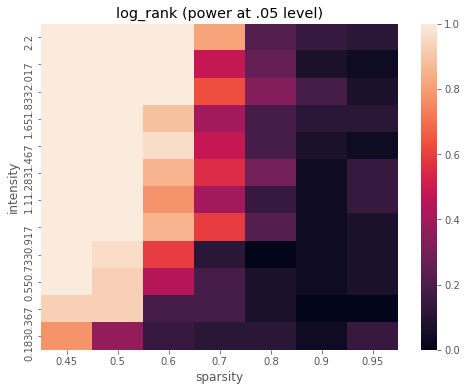

hc: both sides detected in 0.018518518518518517 of cases
(you should be worried if this number is significantly larger than 0.025)


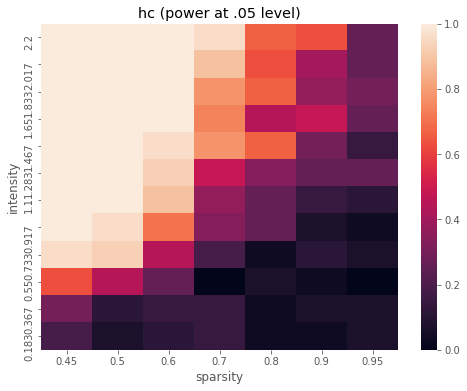

min_p: both sides detected in 0.017195767195767195 of cases
(you should be worried if this number is significantly larger than 0.025)


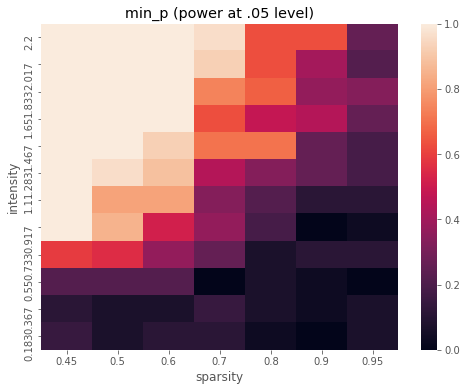

berk_jones: both sides detected in 0.033950617283950615 of cases
(you should be worried if this number is significantly larger than 0.025)


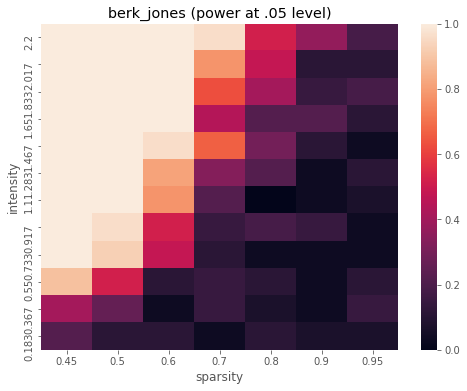

wilcoxon: both sides detected in 0.0 of cases
(you should be worried if this number is significantly larger than 0.025)


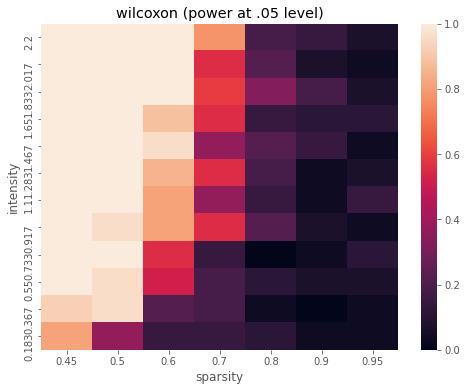

fisher: both sides detected in 0.005731922398589065 of cases
(you should be worried if this number is significantly larger than 0.025)


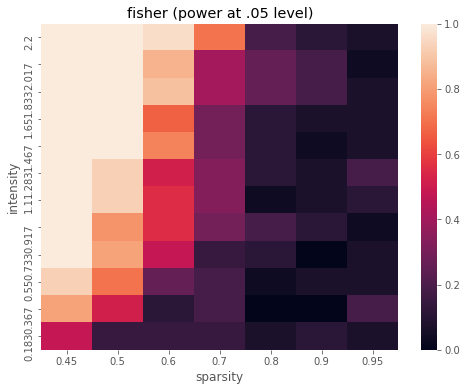

In [146]:
#def illustrate_phase_diagrams(df1, df0, out_filename='phase_diagram'):
"""

Args:
-----
:df1:   results from experiments under alternative 
:df0:   results from experiments under null
:out_filename:   file/path name to write to
"""


params = ['itr', 'T', 'N1', 'N2', 'r', 'beta']
tests = ['log_rank', 'hc', 'min_p', 'berk_jones', 'wilcoxon', 'fisher']
tests_vars = [c for c in df0.columns if c not in params and 'Unnamed' not in c]

global_params = ['T', 'N1', 'N2']
tcrit = df0.groupby(global_params).agg(q95)

good_side = 'greater'
bad_side = 'less'

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]

    for tsn in tests:
        name_good = tsn + '_' + good_side
        name_bad = tsn + '_' + bad_side

        # we check rate when both sides succedds. These are not good outcomes
        two_side_succ = ( dfc[name_good] > tcrit[name_good].values[0] ) & ( dfc[name_bad] > tcrit[name_bad].values[0] )
        print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
        print("(you should be worried if this number is significantly larger than 0.025)")

        bb = dfc['beta'].unique()
        rr = dfc['r'].unique()
        mat = np.zeros((len(bb), len(rr)))
        for i,beta in enumerate(bb):
            for j,r in enumerate(rr):
                dfs = dfc[(dfc['beta'] == beta) & (dfc['r'] == r) ]
                succ = dfs[name_good] > tcrit[name_good].values[0]
                mat[i,j] = np.mean(succ)

        plt.figure()
        g = seaborn.heatmap(mat[:,::-1].T)
        plt.title(f"{tsn} (power at .05 level)")
        g.set_xticklabels(bb)
        g.set_xlabel('sparsity')
        g.set_ylabel('intensity')
        #g.set_yticklabels(np.round(mm[::-1],3))
        g.set_yticklabels(np.round(rr[::-1],3))
        fn = out_filename + tsn + ".png"
        plt.savefig(fn)
        plt.show()